## demo: inferring internal node locations using gaia

In [1]:
library(gaia)
library(tidyr)
library(dplyr)
library(data.table)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [2]:
#library(tidyverse)
library(lubridate)
library(ggplot2)
library(RColorBrewer)
library(viridis)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: viridisLite



In [34]:
library(stringr)

In [3]:
## ggplot theme

my_theme <- function() {
    theme_classic() +
    theme( 
        plot.title = element_text(color="black", size=12, face="bold"),
        axis.title.x = element_text(color="black", size=20, face="bold", vjust=2),
        axis.title.y = element_text(color="black", size=20, face="bold", vjust=2),
        axis.text=element_text(size=24),
        )
}

options(repr.plot.width=14, repr.plot.height=8)

In [4]:
#?treeseq_discrete_mpr

## read tree sequence

In [5]:
filename = "demo.trees"

ts = treeseq_load(filename)

nodes = treeseq_nodes(ts)

edges = treeseq_edges(ts)

# view first local tree 
tree = treeseq_to_phylo(ts)

## extract sample nodes, locations

In [6]:
# identify sample nodes
samples <- subset(nodes, is_sample == 1L)

# use population_id as geography; drop missing values (e.g., -1)
ok       <- samples$population_id >= 0
samples  <- samples[ok, , drop = FALSE]

# remap unique population ids to 1..N_DEMES
pop_levels <- sort(unique(samples$population_id))
state_map  <- setNames(seq_along(pop_levels), pop_levels)
state_id   <- unname(state_map[ as.character(samples$population_id) ])

# georef table for gaia w/ node_id, state_id cols
sample_locations <- data.frame(
  node_id  = samples$node_id,
  state_id = state_id  # Make sure sample locations are 1-based (curr 0-based)
)

sample_locations <- as.matrix(sample_locations[, c("node_id","state_id")])
storage.mode(sample_locations) <- "integer"
colnames(sample_locations) <- c("node_id","state_id")

In [7]:
head(sample_locations)

node_id,state_id
0,1
1,1
2,1
3,1
4,1
5,1


## define cost matrix 

In [8]:
# equally likely transitions/costs 

In [9]:
cost.mat = data.matrix(read.csv("uninformative_cost.csv", row.names=1))[1:3, 1:3]
dimnames(cost.mat) = NULL
cost.mat

0,1,1
1,0,1
1,1,0


In [ ]:
# inverse migration rates

In [ ]:
## import from msprime 

## run mpr function 

In [10]:
#?treeseq_discrete_mpr

In [11]:
#?treeseq_discrete_mpr_minimize 

In [12]:
mpr = treeseq_discrete_mpr(ts, sample_locations, cost.mat)
estimated_node_states = treeseq_discrete_mpr_minimize(mpr) # When multiple states achieve the minimum cost, one is chosen randomly.

In [13]:
#mpr$mpr

In [14]:
head(estimated_node_states, 5) ## node states for the entire tree sequence. 

[1] 1 1 1 1 1

Method applies DTA on per-tree basis. For nodes that appear across multiple trees, the cheapest average location is chosen. 

In [15]:
node_states_df <- data.frame(node_time=nodes$time, node_state=nodes$population_id+1L, 
    estimated_node_state=estimated_node_states)

node_states_df$node <- 0:(nrow(node_states_df) -1)

head(node_states_df,5)

,node_time,node_state,estimated_node_state,node
,<dbl>,<int>,<int>,<int>
1,0,1,1,0
2,0,1,1,1
3,0,1,1,2
4,0,1,1,3
5,0,1,1,4


### Calculate bin-wise accuracy 
Pbin = proportion correctly labeled states / total number of states 

In [16]:
locations_sim <- read.csv('locations_df.csv')
head(locations_sim, 5)

,index,sample_a,sample_b,left,right,mrca_population,type,node,bin,position
,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>
1,0,0,1,0,1897,pop_0,sim,55,0,0
2,0,0,2,0,1897,pop_0,sim,55,0,0
3,0,0,3,0,1897,pop_0,sim,67,0,0
4,0,0,4,0,1897,pop_0,sim,44,0,0
5,0,0,5,0,1897,pop_0,sim,55,0,0


In [17]:
# match up w/ internal node locations(constant) from gaia ->
merged <- left_join(locations_sim, node_states_df, by = 'node')
head(merged, 5)

,index,sample_a,sample_b,left,right,mrca_population,type,node,bin,position,node_time,node_state,estimated_node_state
,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>
1,0,0,1,0,1897,pop_0,sim,55,0,0,1470.6860,1,1
2,0,0,2,0,1897,pop_0,sim,55,0,0,1470.6860,1,1
3,0,0,3,0,1897,pop_0,sim,67,0,0,13415.0423,1,1
4,0,0,4,0,1897,pop_0,sim,44,0,0,211.4219,1,1
5,0,0,5,0,1897,pop_0,sim,55,0,0,1470.6860,1,1


In [18]:
unique(merged$position) ## consider: when i start using tsinfer/tsdate, bin position 0 is going to lower scores due to necessary trimming

[1]     0 10000 20000 30000 40000 50000 60000 70000 80000 90000

In [19]:
# calculate! maybe an average score per bin and then just a scatter/violin plot
score <- merged %>% 
    mutate(merged, is_correct = case_when(node_state == estimated_node_state ~ 1, node_state != estimated_node_state ~ 0)) %>%
    group_by(bin, position) %>%
    summarise(pbin = mean(is_correct)) 

head(score, 5)

`summarise()` has grouped output by 'bin'. You can override using the `.groups` argument.


bin,position,pbin
<int>,<int>,<dbl>
0,0,0.9080460
1,10000,0.9080460
2,20000,0.9080460
3,30000,0.4735632
4,40000,0.9080460


### Plot scores

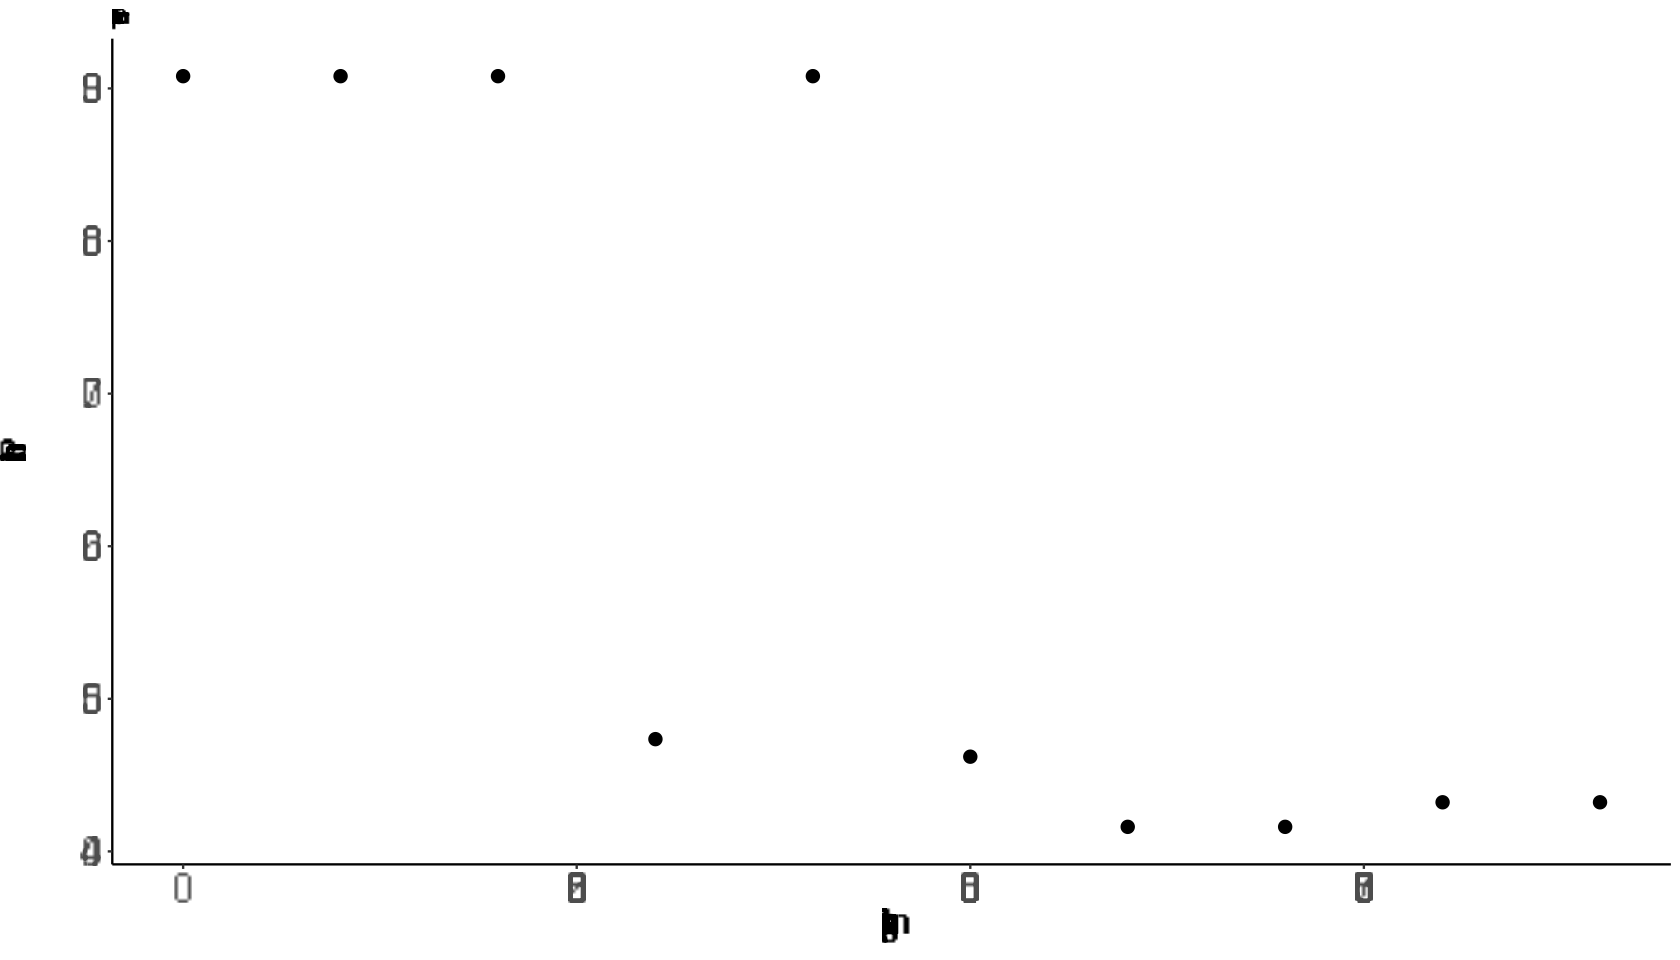

In [20]:
score %>% ggplot(aes(x = position, y = pbin)) + geom_point(size = 3) +
            my_theme() + 
            ylab('Pbin') + xlab('genomic position') + ggtitle('Pbin with uninformative prior')

### MPR node state estimates are random when multiple states achieve the minimum cost.
Here, performing node state inference 50 times and taking an average of accuracy. Can I get a confidence interval out of this? 

In [21]:
mpr_reps <- function(ts, sample_locations, cost.mat, nodes, nrep) {

    node_states_df <- data.frame(node_time=nodes$time, node_state=nodes$population_id+1L)

    for (i in 1:nrep) { 
        mpr <- treeseq_discrete_mpr(ts, sample_locations, cost.mat)
        estimated_node_states <- treeseq_discrete_mpr_minimize(mpr)
        col_n <- paste0('est_',as.character(i))
        node_states_df[[col_n]] = estimated_node_states }

    node_states_df$node <- 0:(nrow(node_states_df) -1)

    return(node_states_df)
    
    }

In [22]:
reps <- left_join(locations_sim, 
                    mpr_reps(ts, sample_locations, cost.mat, nodes, 50), 
                    by = 'node') %>% 
        mutate(across(starts_with("est_"),
               ~ as.integer(. == node_state),
               .names = "score_{.col}"),
    avg_score = rowMeans(across(starts_with("score_")))) 

reps_score <- reps %>%
        # mutate(is_correct = case_when(node_state == estimated_node_state ~ 1, node_state != estimated_node_state ~ 0)) %>%
        group_by(bin, position) %>%
        summarise(pbin = mean(avg_score)) 

`summarise()` has grouped output by 'bin'. You can override using the `.groups` argument.


Saving 6.67 x 6.67 in image


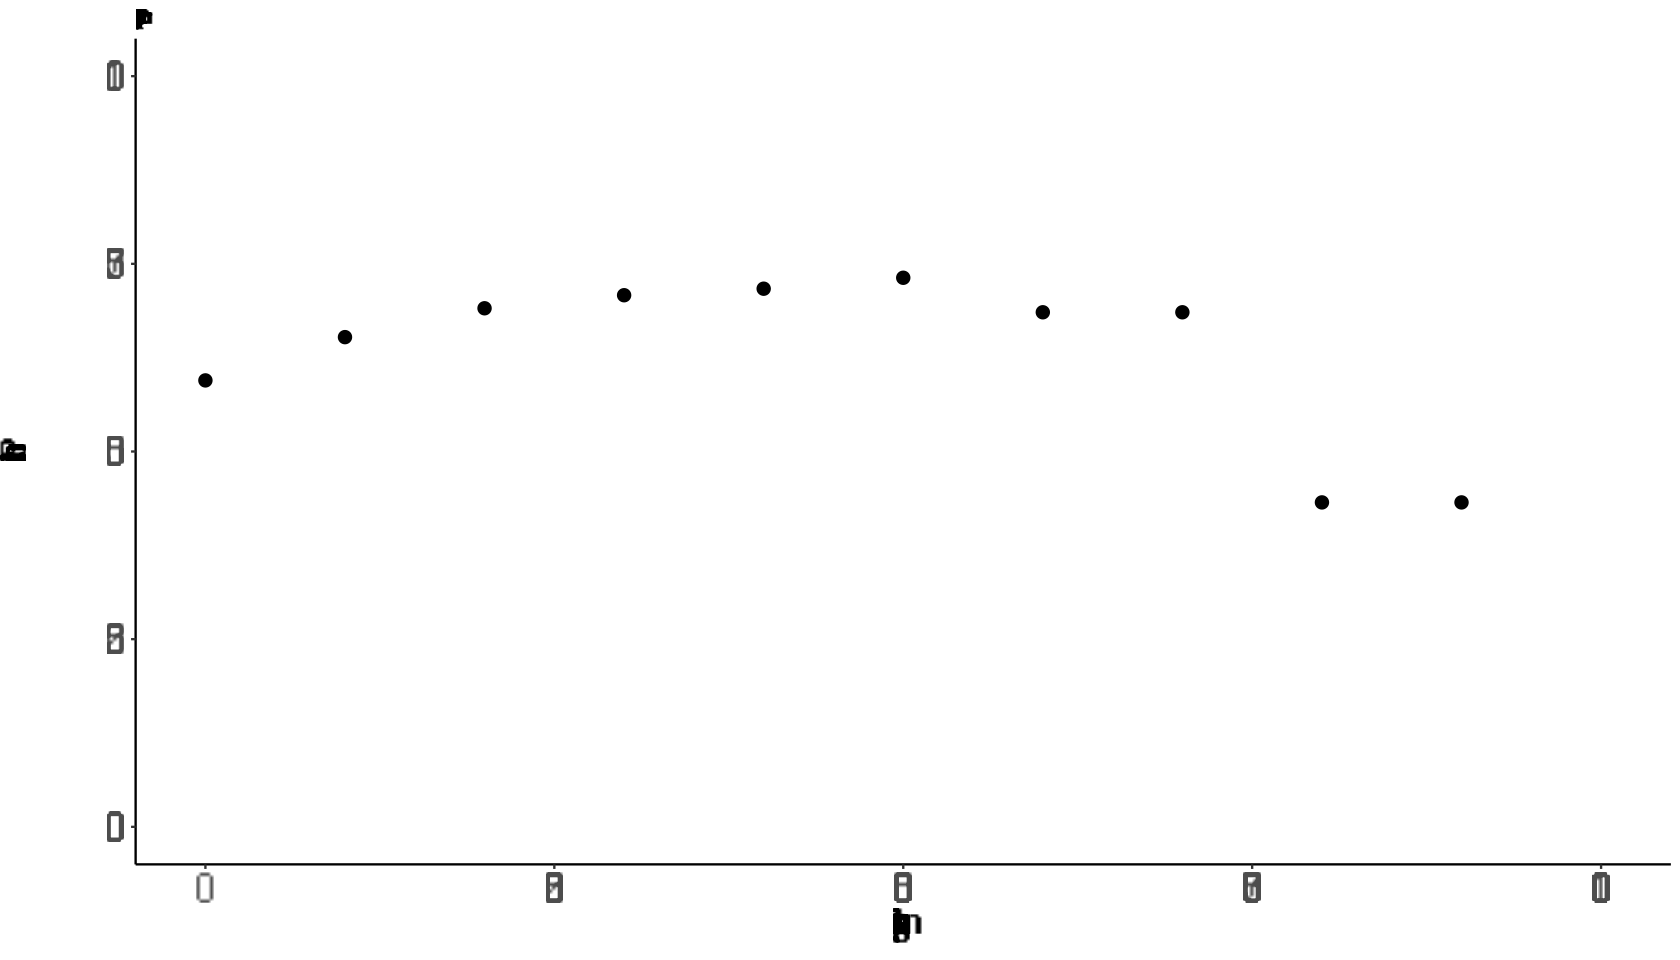

In [23]:
reps_score %>% ggplot(aes(x = position, y = pbin)) + geom_point(size = 3) +
            my_theme() + 
            ylab('Pbin') + xlab('genomic position') + ggtitle('Pbin with uninformative prior (50 reps)') + 
            #ylim(0,1.0) + xlim(0, 100000) + 
            coord_cartesian(ylim = c(0,1.0), xlim = c(0,100000)) +
            scale_y_continuous(breaks = c(0, .25, 0.5, 0.75, 1.0))

ggsave("reps_50.png")

# Getting confidence intervals (accuracy)

Treat as binomial proportion problem, so
- pbin = proportion of correct runs across N replicates (probability that mpr gives me a correct answer for that bin)
- calculate uncertainty/standard error of pbin

In [24]:
reps_long <- reps %>%
  pivot_longer(
    cols = starts_with("score_"),
    names_to = "rep",
    values_to = "score"
  )

reps_score <- reps_long %>%
  group_by(bin, position) %>%
  summarise(
    pbin = mean(score),
    n = n(),
    se = sqrt(pbin * (1 - pbin) / n), # standard error of a binomial proportion using n trials
    lwr = pbin - 1.96 * se, # 95% CI, lower 
    upr = pbin + 1.96 * se, # 95% CI, upper  
    .groups = "drop"
  )


In [25]:
reps_score

bin,position,pbin,n,se,lwr,upr
<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
0,0,0.5947126,21750,0.003328936,0.5881879,0.6012374
1,10000,0.6523678,21750,0.003229064,0.6460389,0.6586968
2,20000,0.6908046,21750,0.003133751,0.6846624,0.6969467
3,30000,0.7081839,21750,0.003082464,0.7021423,0.7142255
4,40000,0.7168736,21750,0.003054794,0.7108862,0.7228610
5,50000,0.7314483,21750,0.003005219,0.7255580,0.7373385
6,60000,0.6854713,21750,0.003148438,0.6793003,0.6916422
7,70000,0.6854713,21750,0.003148438,0.6793003,0.6916422
8,80000,0.4321839,21750,0.003358988,0.4256003,0.4387675


Saving 6.67 x 6.67 in image


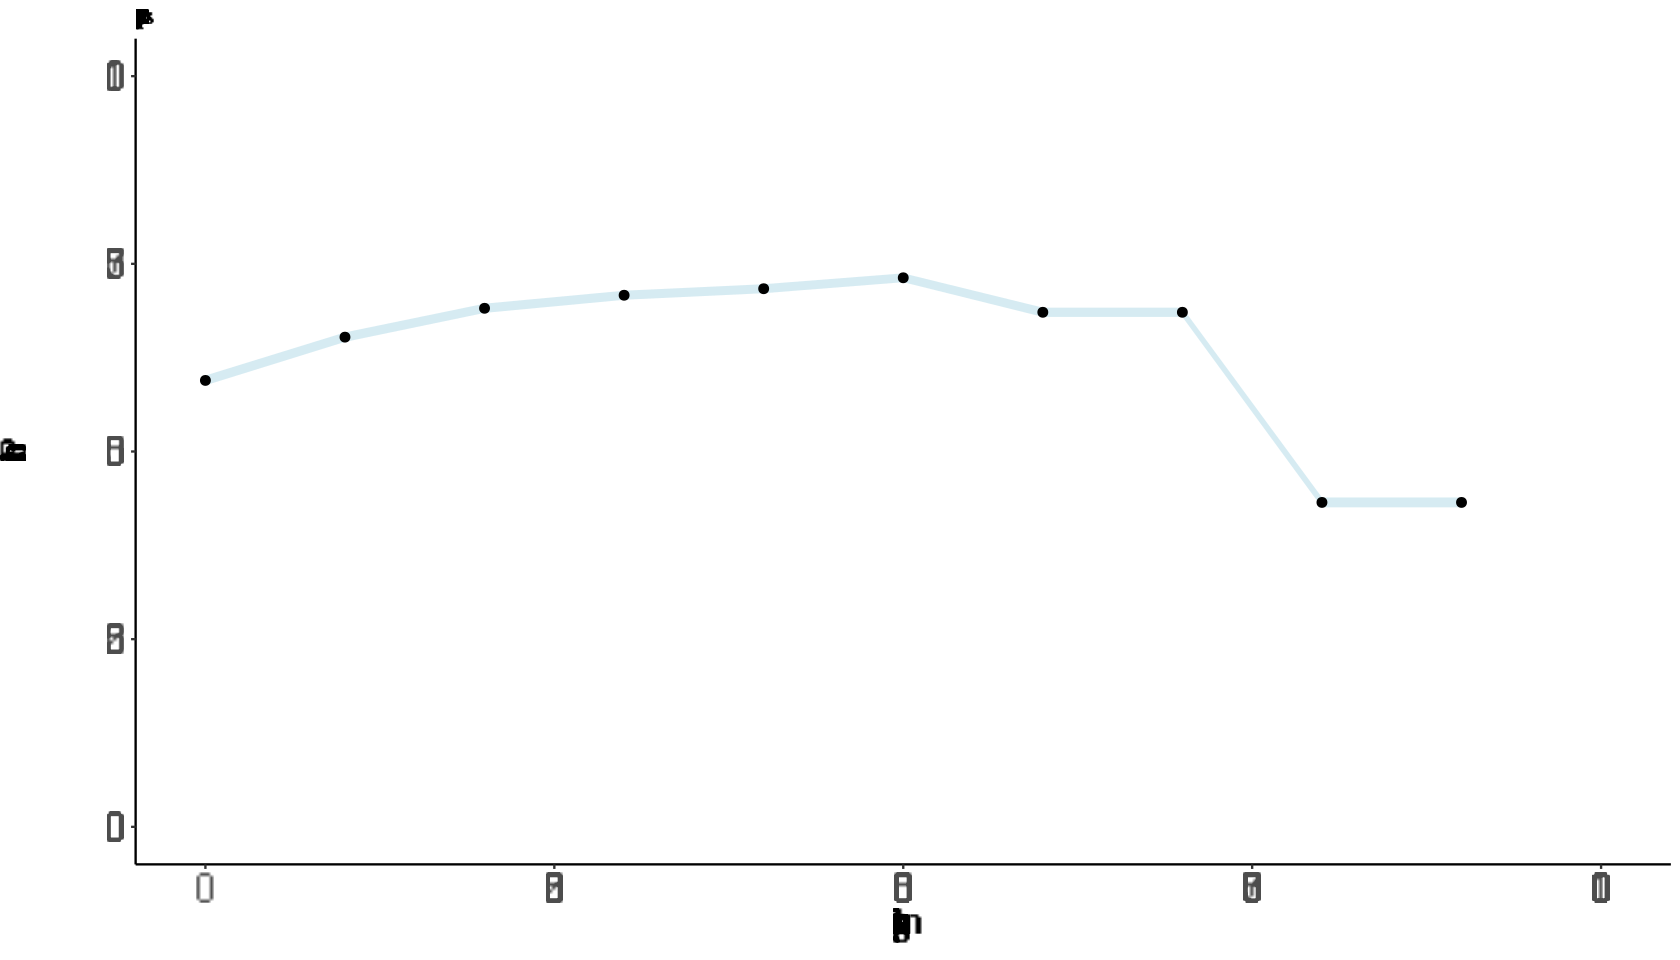

In [26]:
ggplot(reps_score, aes(x = position, y = pbin)) +
  geom_ribbon(aes(ymin = lwr, ymax = upr), alpha = 0.5, fill = "lightblue") +
  geom_point(size = 2) +
  coord_cartesian(ylim = c(0,1), xlim = c(0,100000)) +
  my_theme() +
  ylab("Pbin") + scale_y_continuous(breaks = c(0, .25, 0.5, 0.75, 1.0)) +
  xlab("genomic position") + ggtitle('Pbin with 95% CI (50 reps)')

ggsave("reps_50_se.png")

# Getting location probabilities 
For each mrca(a, b) and bin, calculate P(loc_1), P(loc_2), and P(loc_3) as was estimated across N reps


In [27]:
reps <- left_join(locations_sim, 
                    mpr_reps(ts, sample_locations, cost.mat, nodes, 50), 
                    by = 'node')

reps_long <- reps %>%
             pivot_longer(
                cols = starts_with("est_"),
                names_to  = "rep",
                values_to = "est_state"
              ) %>%
              mutate(est_state = as.character(est_state))


# averaging over 50 reps 
p_location_sample <- reps_long %>%
  group_by(sample_a, sample_b, bin, node_state, position, est_state) %>%
  summarise(n = n(), .groups = "drop_last") %>%
  mutate(
    total = sum(n),
    p = n / total
  ) %>%
  ungroup()

head(p_location_sample, 5)

sample_a,sample_b,bin,node_state,position,est_state,n,total,p
<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>
0,1,0,1,0,1,50,50,1
0,1,1,1,10000,1,50,50,1
0,1,2,1,20000,1,50,50,1
0,1,3,1,30000,1,50,50,1
0,1,4,1,40000,1,50,50,1


## Recreating Lucy's [plots](https://docs.google.com/presentation/d/1jo0xf-13YQJao7pCsDZ3W8OSt6v8IScK65xFG4_LUjo/edit?slide=id.p#slide=id.p)  

- measure inference accuracy per-label 
- measure location probabilities per-label 

In [28]:
p_wide <- p_location_sample %>%
  mutate(est_state = paste0("p", est_state)) %>%   # 1 -> p1, 2 -> p2, 3 -> p3
  select(-n, -total) %>%
  pivot_wider(
    names_from  = est_state,
    values_from = p,
    values_fill = 0
  )

head(p_wide, 5)

sample_a,sample_b,bin,node_state,position,p1,p2,p3
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
0,1,0,1,0,1,0,0
0,1,1,1,10000,1,0,0
0,1,2,1,20000,1,0,0
0,1,3,1,30000,1,0,0
0,1,4,1,40000,1,0,0


### (1) proportion of correct predictions across groups
the proportion of runs that output state k for a given true state j

In [29]:
p_wide %>%
  pivot_longer(
    cols = num_range('p', 0:9),
    names_to = "est_state",
    values_to = "p"
  ) %>%
  group_by(node_state, est_state) %>%
  summarise(p = mean(p), .groups = "drop") %>%
  pivot_wider(
    names_from = est_state,
    values_from = p
  )

node_state,p1,p2,p3
<int>,<dbl>,<dbl>,<dbl>
1,0.7197787,0.01798955,0.2622318
2,0.8388953,0.16110472,0.0000000
3,0.0000000,0.00000000,1.0000000


In [52]:
proportions_correct <- p_wide %>%
  pivot_longer(
    cols = num_range('p', 0:9),
    names_to = "est_state",
    values_to = "p"
  ) %>%
  group_by(node_state, est_state) %>%
  summarise(p = mean(p), .groups = "drop") %>%
  mutate(is_true = case_when(str_detect(est_state, as.character(node_state)) ~ TRUE,
                                                          TRUE ~ FALSE
  )) %>% mutate(node_state = as.character(node_state))

proportions_correct

node_state,est_state,p,is_true
<chr>,<chr>,<dbl>,<lgl>
1,p1,0.71977867,TRUE
1,p2,0.01798955,FALSE
1,p3,0.26223179,FALSE
2,p1,0.83889528,FALSE
2,p2,0.16110472,TRUE
2,p3,0.00000000,FALSE
3,p1,0.00000000,FALSE
3,p2,0.00000000,FALSE
3,p3,1.00000000,TRUE


Warning message:
“The `labeller` API has been updated. Labellers taking `variable` and `value` arguments are now deprecated.
ℹ See labellers documentation.”
Saving 6.67 x 6.67 in image


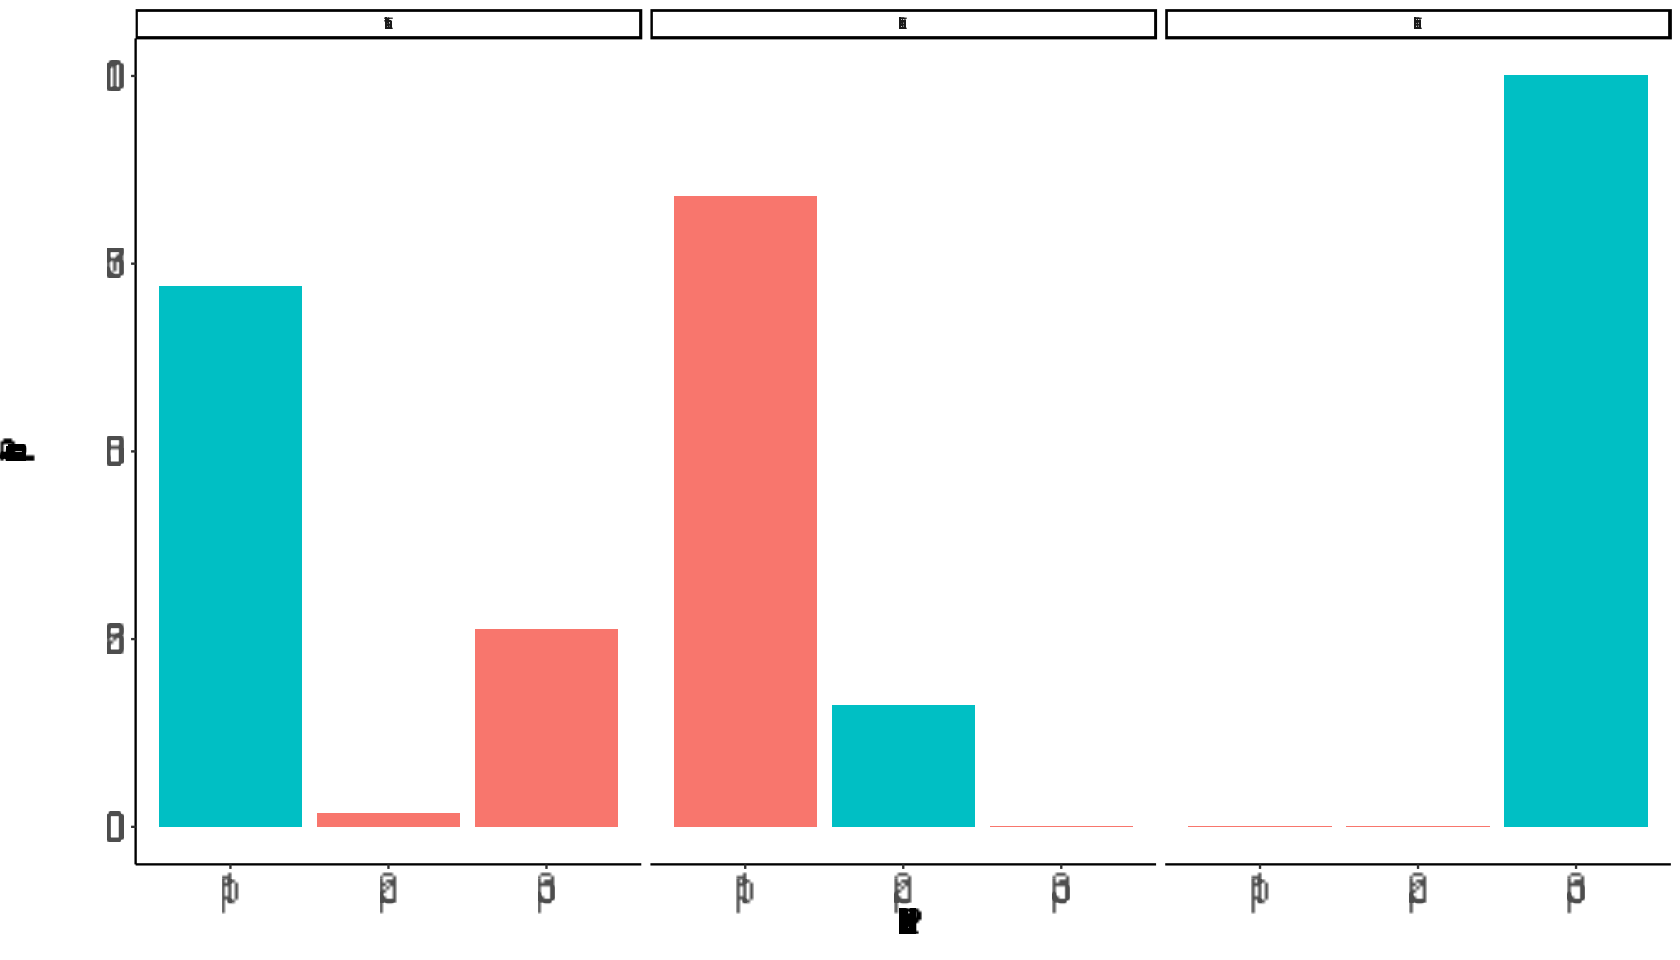

In [55]:
group_labels <- list('1' = 'True location 1',
                     '2' = 'True location 2',
                     '3' = 'True location 3') 

group_labeller <- function(variable,value){
  return(group_labels[value])
}

ggplot(proportions_correct, aes(x = est_state, y = p, fill = is_true)) +
  geom_col() +
  my_theme() +
  ylab("Proportion") + #ylim(0, 1.0) 
  xlab("Predicted label") +
  facet_wrap(~node_state, ncol = 3, labeller = group_labeller) + theme(legend.position="none")
  #labs(fill = "inferred state")

ggsave("label_proportions.png")

### (2) distribution of location probabilities across groups 

the estimated probability that gaia infers state k, given the true state is j
-> the fraction of runs that output k 

In [66]:
# pooling nodes that are in the same bin, same true position 

prob_est <- reps_long %>%
  group_by(bin, position, node_state, est_state) %>%
  summarise(n = n(), .groups = "drop_last") %>%
  mutate(
    N = sum(n),
    p_hat = n / N
  ) %>%
  ungroup()

head(prob_est, 5)

bin,position,node_state,est_state,n,N,p_hat
<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>
0,0,1,1,9472,18450,0.5133875
0,0,1,2,2926,18450,0.1585908
0,0,1,3,6052,18450,0.3280217
0,0,2,1,1300,2000,0.6500000
0,0,2,2,700,2000,0.3500000


In [69]:
prob_est$bin

[1] 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7
[39] 7 7 7 8 8 8 8 8 9 9 9 9 9

Saving 6.67 x 6.67 in image


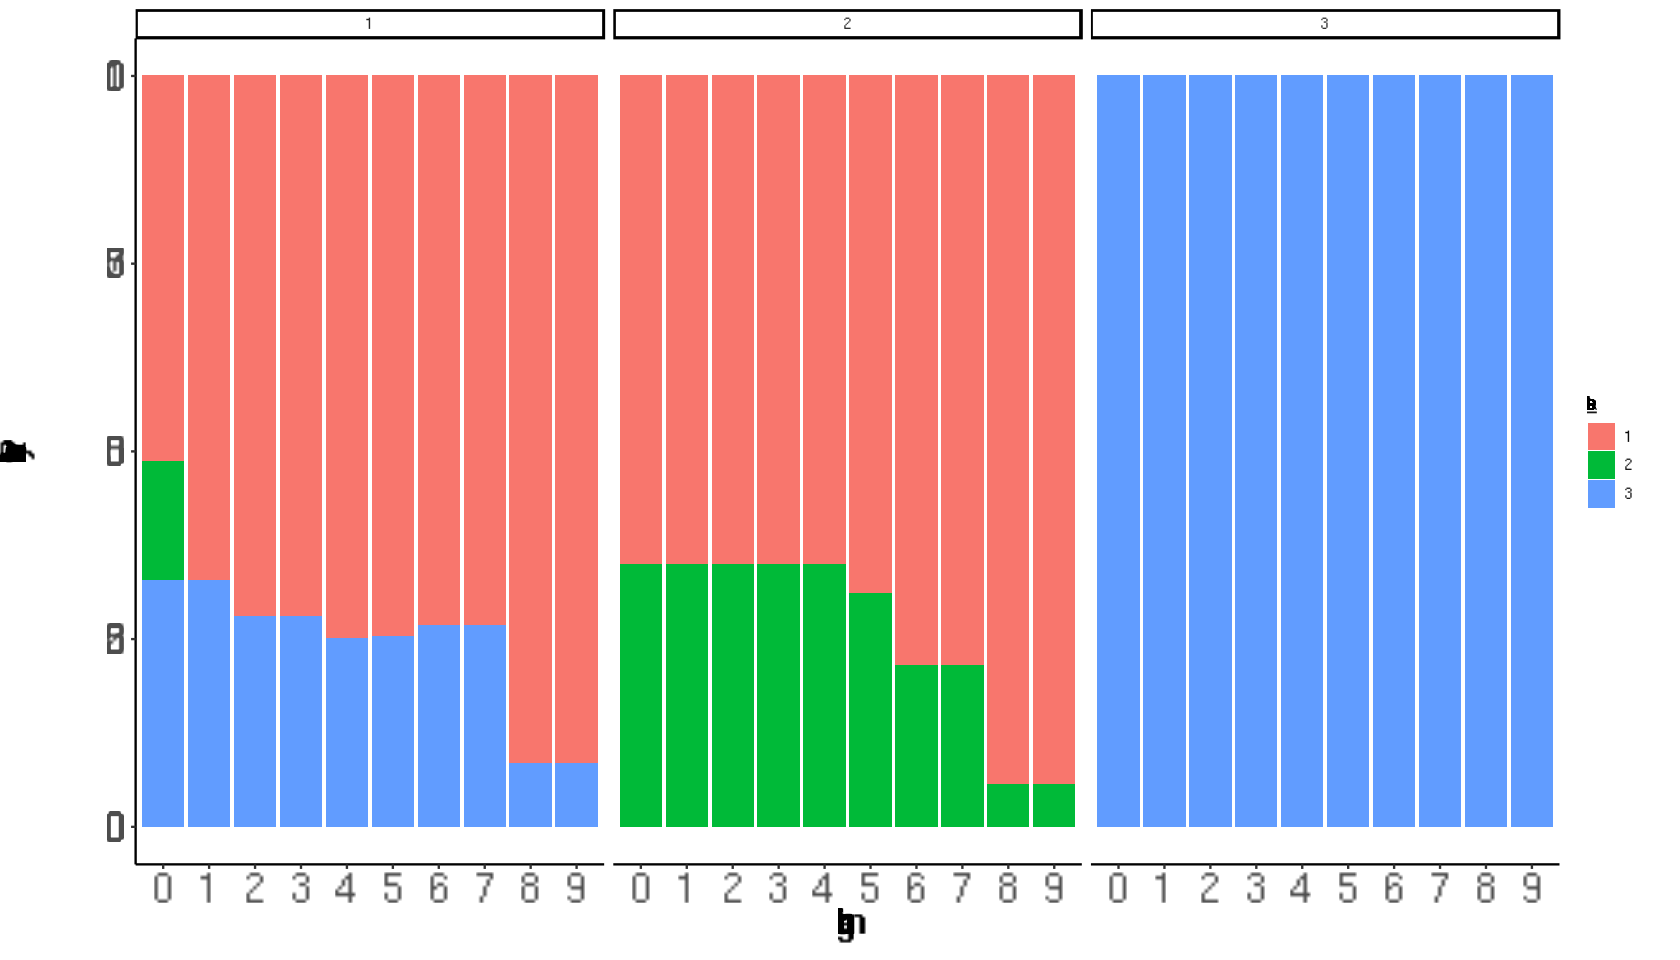

In [71]:
ggplot(prob_est, aes(x = as.character(bin), y = p_hat, fill = est_state)) +
  geom_col() +
  my_theme() +
  ylab("Probability") + facet_wrap(~node_state) + ylim(0, 1.0) +
  xlab("genomic bin") #+ xlim(0, 100000) 
  #labs(fill = "inferred state") 

ggsave("bin_location_probability.png")